<a href="https://colab.research.google.com/github/ayoakin/MIVLDE/blob/LLMProbing/ODEFormer_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ODEFormer


In [1]:
import numpy as np
import matplotlib.pyplot as plt

!pip install odeformer
import odeformer
from odeformer.model import SymbolicTransformerRegressor
from odeformer.metrics import r2_score

dstr = SymbolicTransformerRegressor(
    from_pretrained=True)

model_args = {'beam_size':20,
        'beam_temperature':0.1}
dstr.set_model_args(model_args)
print("pushDif")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

Downloading...
From (original): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W
From (redirected): https://drive.google.com/uc?id=1L_UZ0qgrBVkRuhg5j3BQoGxlvMk_Pm1W&confirm=t&uuid=0dea471e-172f-43ca-9ee9-6131f6f9d18f
To: /content/odeformer.pt
100%|██████████| 465M/465M [00:05<00:00, 78.0MB/s]


Loaded pretrained model


In [6]:
times = np.linspace(0, 10, 50)
x = 2.3*np.cos(times+.5)
y = 1.2*np.sin(times+.1)
trajectory = np.stack([x, y], axis=1)

dstr.fit(times, trajectory)
pred_traj = dstr.predict(times, trajectory[0])

dstr.print()
r2_score(trajectory, pred_traj)

x_0' = -0.3118 * x_0 + -1.9788 * x_1
x_1' = 0.5561 * x_0 + 0.3268 * x_1


0.9953393207771408

In [10]:
times = np.linspace(0, 10, 50)
x = 2.3*np.cos(times+.5)

trajectory = np.stack([x], axis=1)

dstr.fit(times, trajectory)
pred_traj = dstr.predict(times, trajectory[0])

dstr.print()
r2_score(trajectory, pred_traj)

x_0' = 1.9928 * sin(-1.0570 + 8.8534 * x_0) + -3.0101 * sin(1.0260 + 4.9940 * x_0 * (-0.0559 + 5.1723 * x_0)**-1)


0.04170768446089945

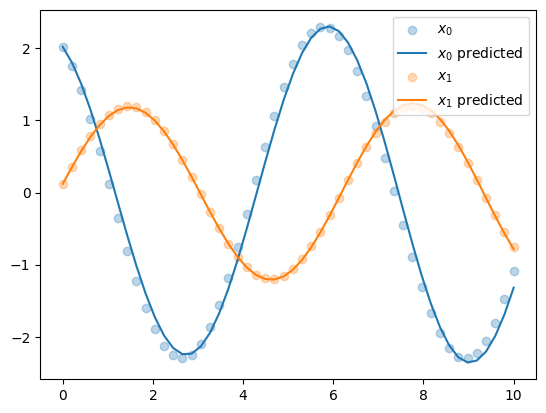

In [3]:
pred_traj = dstr.predict(times, trajectory[0])
dimension = len(trajectory[0])
for dim in range(dimension):
    plt.scatter(times, trajectory[:, dim], color = f'C{dim}', label=f'$x_{dim}$', marker='o', alpha=.3)
    plt.plot(times, pred_traj[:, dim],  color = f'C{dim}', label=f'$x_{dim}$ predicted')
plt.legend()

In [12]:
import numpy as np
import scipy.integrate
import sympy as sp
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

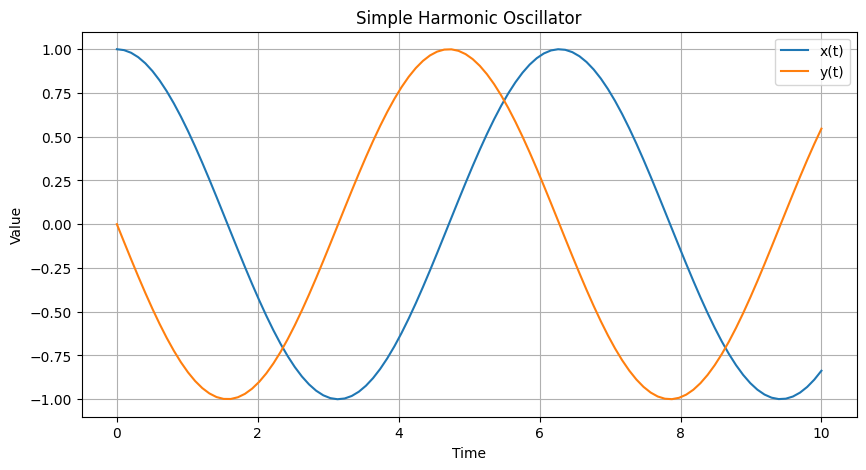

In [13]:
def parse_system(system):
    """Parse ODE system using SymPy."""
    equations = [eq.strip() for eq in system.split(',')]
    expressions = []

    vars = []
    for eq in equations:
        var = eq.split('/')[0].strip()[1:]
        vars.append(var)

    for eq in equations:
        right = eq.split('=')[1].strip()
        expressions.append(sp.sympify(right))

    return sp.lambdify(vars, expressions, modules='numpy')

def integrate_ode(y0, times, system, events=None, debug=False):
    """Integrate an ODE system."""
    system_fn = parse_system(system)

    try:
        sol = scipy.integrate.solve_ivp(
            lambda t, y: system_fn(*y),
            (min(times), max(times)),
            y0,
            t_eval=times,
            events=events
        )
        return sol.y.T

    except Exception as e:
        if debug:
            import traceback
            print(traceback.format_exc())
        return None

if __name__ == "__main__":
    # Example 1: Simple harmonic oscillator (2D)
    system = "dx/dt = y, dy/dt = -x"
    y0 = np.array([1.0, 0.0])
    t = np.linspace(0, 10, 100)

    trajectory = integrate_ode(y0, t, system, debug=True)

    if trajectory is not None:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(t, trajectory[:, 0], label='x(t)')
        plt.plot(t, trajectory[:, 1], label='y(t)')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simple Harmonic Oscillator')
        plt.legend()
        plt.grid(True)
        plt.show()

In [20]:
if __name__ == "__main__":
    # Example 1: Simple harmonic oscillator (2D)
    system = "dx/dt = -2.3*x"
    y0 = np.array([1.0, 0.0])
    t = np.linspace(0, 10, 100)

    trajectory = integrate_ode(y0, t, system, debug=True)

    if trajectory is not None:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(t, trajectory[:, 0], label='x(t)')
        plt.plot(t, trajectory[:, 1], label='y(t)')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simple Harmonic Oscillator')
        plt.legend()
        plt.grid(True)
        plt.show()

Traceback (most recent call last):
  File "<ipython-input-13-fce1bb08a906>", line 22, in integrate_ode
    sol = scipy.integrate.solve_ivp(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/ivp.py", line 621, in solve_ivp
    solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/rk.py", line 94, in __init__
    self.f = self.fun(self.t, self.y)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/base.py", line 154, in fun
    return self.fun_single(t, y)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/base.py", line 23, in fun_wrapped
    return np.asarray(fun(t, y), dtype=dtype)
                      ^^^^^^^^^
  File "<ipython-input-13-fce1bb08a906>", line 23, in <lambda>


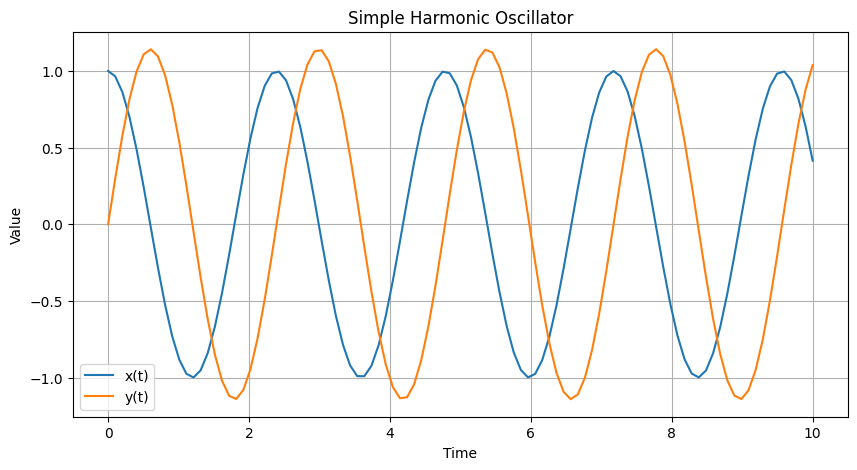

In [19]:
if __name__ == "__main__":
    # Example 1: Simple harmonic oscillator (2D)
    system = "dx/dt = -2.3*y, dy/dt = 3*x"
    y0 = np.array([1.0, 0.0])
    t = np.linspace(0, 10, 100)

    trajectory = integrate_ode(y0, t, system, debug=True)

    if trajectory is not None:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 5))
        plt.plot(t, trajectory[:, 0], label='x(t)')
        plt.plot(t, trajectory[:, 1], label='y(t)')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Simple Harmonic Oscillator')
        plt.legend()
        plt.grid(True)
        plt.show()

In [8]:
!pip install --upgrade odeformer


# ODEBench

Here we reproduce the results of Figure 1.
Since Colab is not equipped with GPU support, we use a rather small batch size to obtain fast inference (10 instead of 50 in the paper), so results are a bit worse.
Feel free to test at beam size 50!

In [9]:
from odeformer.odebench.strogatz_equations import equations
from odeformer.odebench.solve_and_plot import config, process_equations, solve_equations, plot_prediction

indices = [9,16,27,40,52,54,62,63]
equations = [equations[i-1] for i in indices]
process_equations(equations)
solve_equations(equations, config)

ModuleNotFoundError: No module named 'odeformer.odebench'

In [5]:
for equation in equations:
    plot_prediction(dstr, equation, seed=0, noise=.05, subsampling=.5)

NameError: name 'equations' is not defined